Paquetes necesarios

In [3]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



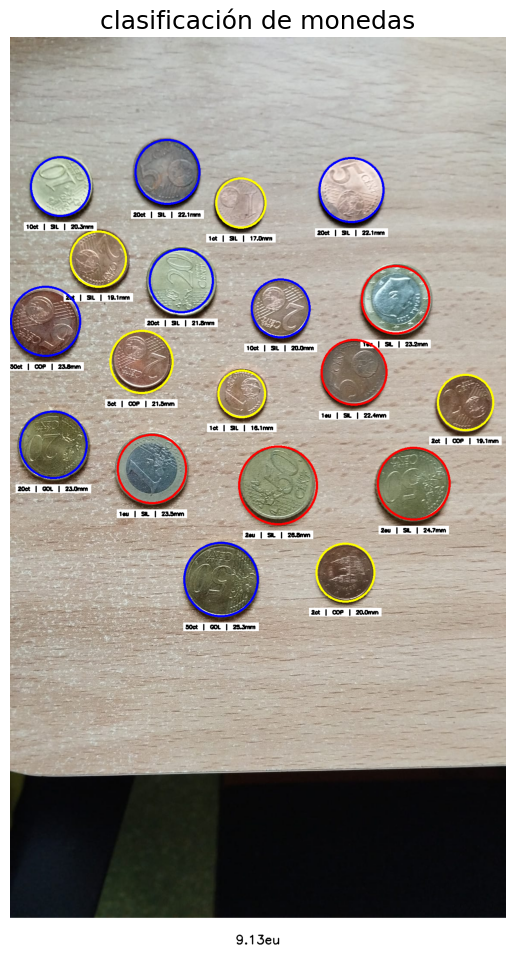

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Definición de los diámetros conocidos de las monedas en milímetros
COIN_DIAMETERS_MM = {
    1: 16.25,
    2: 18.75,
    5: 21.25,
    10: 19.75,
    20: 22.25,
    50: 24.25,
    100: 23.25,
    200: 25.75
}

# Función para seleccionar la moneda de referencia (1 euro) mediante clic del ratón
def select_reference_coin(event, x, y, flags, params):
    global reference_coin
    if event == cv2.EVENT_LBUTTONDOWN and circles is not None:
        for idx, (cx, cy, d) in enumerate(circles[0, :]):

            cx, cy, x, y = map(float, [cx, cy, x, y])
            if np.hypot(x - cx, y - cy) <= d:
                reference_coin = (cx, cy, d)
                cv2.circle(display_img, (int(cx), int(cy)), int(d), (0, 0, 255), 3)
                cv2.putText(display_img, "1 Euro", (int(cx - 40), int(cy - d - 10)),
                            cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 0, 255), 2)
                cv2.imshow("clica en la moneda de 1€", display_img)
                cv2.waitKey(500)
                cv2.destroyAllWindows()
                return

# Función para analizar el color promedio en HSV
def analyze_coin_color(x, y, patch_size=5):
    height, width = img_hsv.shape[:2]
    half = patch_size // 2
    x1, x2 = max(x - half, 0), min(x + half + 1, width)
    y1, y2 = max(y - half, 0), min(y + half + 1, height)
    
    # Extrae el parche y calcula el promedio en HSV
    patch = img_hsv[y1:y2, x1:x2]
    mean_hsv = np.mean(patch, axis=(0, 1))  # Promedio HSV
    h, s, v = mean_hsv  # OpenCV HSV: H 0-180, S/V 0-255
    
    # Normaliza los valores
    h = h * 2  # a 0-360 grados
    s = s / 255.0
    v = v / 255.0
    
    # Clasificación ajustada basada en rangos HSV investigados
    if s < 0.25:
        return "SILVER"
    elif 0 < h < 70 and s > 0.2 and v > 0.2:
        if h < 35:
            return "COPPER"
        else:
            return "GOLD"
    else:
        return "UNKNOWN"

# 1. Carga y preprocesamiento de la imagen
img = cv2.imread('Monedas 2.jpg')  # Carga la imagen
if img is None:
    raise FileNotFoundError("No se pudo cargar la imagen. Verifica la ruta.")
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # Convierte a espacio de color HSV
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convierte a escala de grises
img_blurred = cv2.medianBlur(img_gray, 5)  # Aplica desenfoque para reducir ruido
display_img = cv2.cvtColor(img_blurred, cv2.COLOR_GRAY2BGR)  # Convierte a BGR para visualización

# 2. Detección de círculos en la imagen usando la transformada de Hough
circles = cv2.HoughCircles(
    img_blurred, cv2.HOUGH_GRADIENT, 1, 100, 
    param1=100, param2=50, minRadius=10, maxRadius=150
)
circles = np.uint16(np.around(circles)) if circles is not None else None
circle_diameters = {idx + 1: d for idx, (_, _, d) in enumerate(circles[0, :])} if circles is not None else {}

# 3. Selección interactiva de la moneda de 1 euro
reference_coin = None
cv2.namedWindow("clica en la moneda de 1€", cv2.WINDOW_NORMAL)
cv2.imshow("clica en la moneda de 1€", img)
cv2.setMouseCallback("clica en la moneda de 1€", select_reference_coin)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 4. Clasificación de monedas por tamaño relativo al euro
size_classifications = []
for idx, d in circle_diameters.items():
    cx, cy, _ = circles[0, idx - 1]
    diameter_mm = d / reference_coin[2] * COIN_DIAMETERS_MM[100] if reference_coin else 0
    differences = [(value, abs(diameter_mm - d_mm)) for value, d_mm in COIN_DIAMETERS_MM.items()]
    differences.sort(key=lambda x: x[1])
    size_classifications.append((idx, [differences[0][0], differences[1][0]]))

# 5. Clasificación por color usando el método HSV
INITIAL_PATCH_SIZE = 5
LARGER_PATCH_SIZE = 10
coin_colors = {}
for idx, (cx, cy, d) in enumerate(circles[0, :], 1):
    cx, cy = int(cx), int(cy)
    points = [
        (cx, cy),  # centro
        (int(cx - 0.9 * d), cy),  # izquierda
        (int(cx + 0.9 * d), cy),  # derecha
        (cx, int(cy - 0.9 * d)),  # arriba
        (cx, int(cy + 0.9 * d))   # abajo
    ]
    
    colors_initial = [analyze_coin_color(px, py, INITIAL_PATCH_SIZE) for px, py in points]
    color_count = Counter(colors_initial)
    
    if "SILVER" in color_count:
        final_color = "SILVER"
    else:
        final_color = color_count.most_common(1)[0][0] if color_count else "UNKNOWN"
    
    if final_color == "UNKNOWN" or len(set(colors_initial)) > 2:
        colors_large = [analyze_coin_color(px, py, LARGER_PATCH_SIZE) for px, py in points]
        color_count = Counter(colors_large)
        if "SILVER" in color_count:
            final_color = "SILVER"
        else:
            final_color = color_count.most_common(1)[0][0] if color_count else "UNKNOWN"

    coin_colors[idx] = final_color

# 6. Combinación de clasificaciones por tamaño y color
COPPER_COINS = [1, 2, 5]
GOLD_COINS = [10, 20, 50]
SILVER_COINS = [100, 200]
final_classifications = []

for idx, candidates in size_classifications:
    color = coin_colors.get(idx, "UNKNOWN")
    color_group = (
        COPPER_COINS if color == "COPPER" else
        GOLD_COINS if color == "GOLD" else
        SILVER_COINS if color == "SILVER" else []
    )
    valid_candidates = [v for v in candidates if v in color_group]
    
    if valid_candidates:
        if len(valid_candidates) == 1:
            final_value = valid_candidates[0]
        else:
            cx, cy, d_px = circles[0, idx - 1]
            diameter_mm = d_px / reference_coin[2] * COIN_DIAMETERS_MM[100] if reference_coin else 0
            final_value = min(valid_candidates, key=lambda v: abs(COIN_DIAMETERS_MM[v] - diameter_mm))
    else:
        final_value = candidates[0]
    
    final_classifications.append((idx, final_value, color))

# 7. Cálculo del valor total y conteo de monedas
coin_counts = {value: 0 for value in COIN_DIAMETERS_MM}
total_cents = 0
for _, value, _ in final_classifications:
    coin_counts[value] += 1
    total_cents += value

euros, cents = divmod(total_cents, 100)
total_text = f"{euros}.{cents:02d}eu"

# 8. Creación de la imagen final con anotaciones
img_final = img.copy()
for idx, value, color in final_classifications:
    cx, cy, d = circles[0, idx - 1]
    diameter_mm = d / reference_coin[2] * COIN_DIAMETERS_MM[100] if reference_coin else 0
    label = f"{value//100}eu" if value >= 100 else f"{value}ct"
    text = f"{label}  |  {color[:3]}  |  {diameter_mm:.1f}mm"

    if value in [1, 2, 5]:
        border_color = (0, 255, 255)  # Amarillo
    elif value in [10, 20, 50]:
        border_color = (255, 0, 0)    # Azul
    elif value in [100, 200]:
        border_color = (0, 0, 255)    # Rojo

    cv2.circle(img_final, (int(cx), int(cy)), int(d), border_color, 3)

    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = max(0.2, min(0.4, d / 100.0))
    thickness = 1 if d < 50 else 2
    text_size = cv2.getTextSize(text, font, scale, thickness)[0]
    text_x, text_y = int(cx - text_size[0] / 2), int(cy + text_size[1] / 2 + d + 25)

    cv2.rectangle(img_final, (text_x - 5, text_y - text_size[1] - 5),
                  (text_x + text_size[0] + 5, text_y + 5), (255, 255, 255), -1)
    cv2.putText(img_final, text, (text_x, text_y), font, scale, (0, 0, 0), thickness)

# 9. Agrega el valor total centrado en la parte inferior
height, width = img_final.shape[:2]
extra_height = 100
img_with_total = np.zeros((height + extra_height, width, 3), dtype=np.uint8)
img_with_total[:height, :width] = img_final
img_with_total[height:height + extra_height, :width] = 255

font = cv2.FONT_HERSHEY_SIMPLEX
scale = max(0.8, min(1.5, width / 1200.0))
thickness = 2
text_size = cv2.getTextSize(total_text, font, scale, thickness)[0]
text_x = (width - text_size[0]) // 2
text_y = height + 60
cv2.putText(img_with_total, total_text, (text_x, text_y), font, scale, (0, 0, 0), thickness)

# 10. Muestra la imagen final con las clasificaciones y el valor total
plt.figure(figsize=(18, 12))
plt.imshow(cv2.cvtColor(img_with_total, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("clasificación de monedas", fontsize=18)
plt.show()


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

[INFO] Imagen fragment-03-olympus-10-01-2020.JPG - detecciones visualizadas (78 contornos)


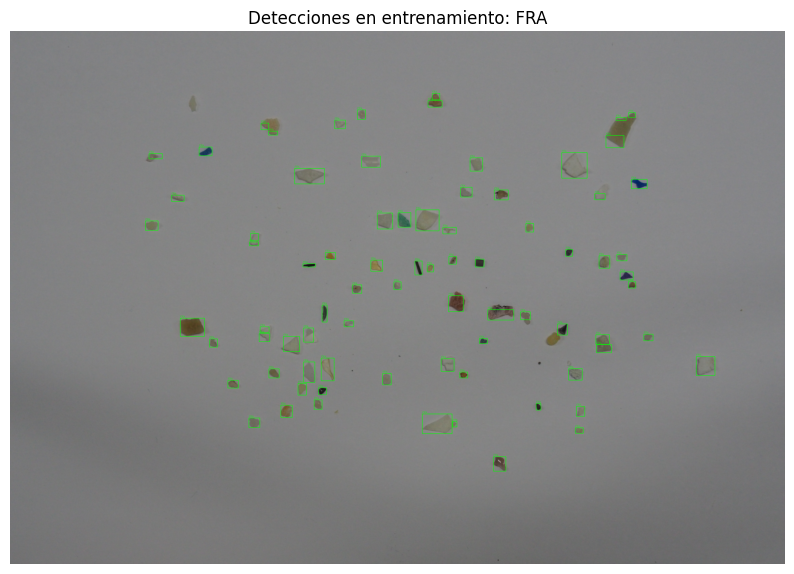

[INFO] Imagen pellet-03-olympus-10-01-2020.JPG - detecciones visualizadas (58 contornos)


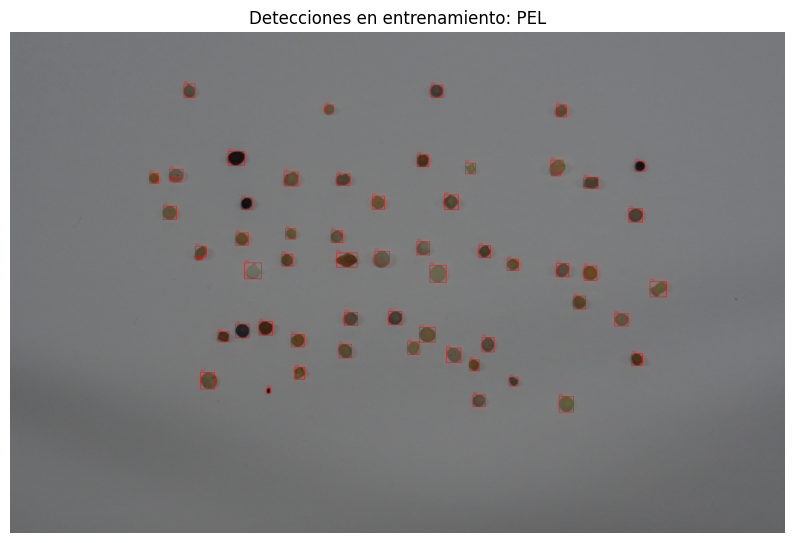

[INFO] Imagen tar-03-olympus-10-01-2020.JPG - detecciones visualizadas (54 contornos)


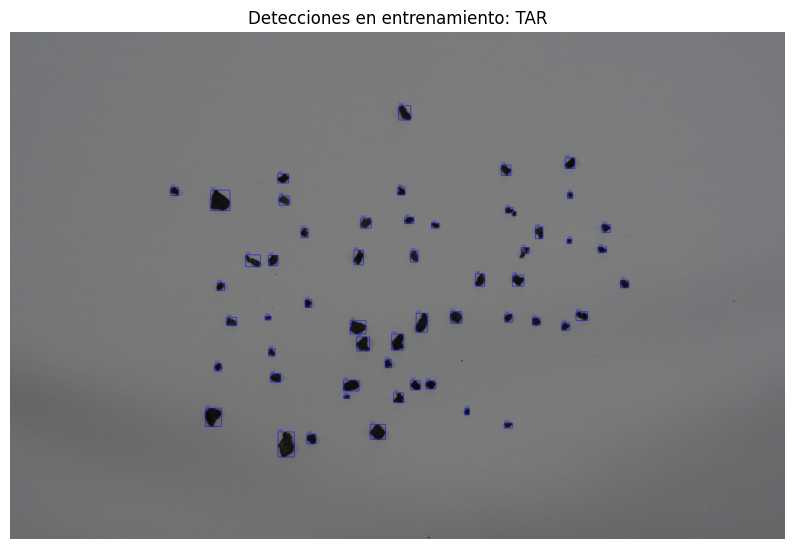

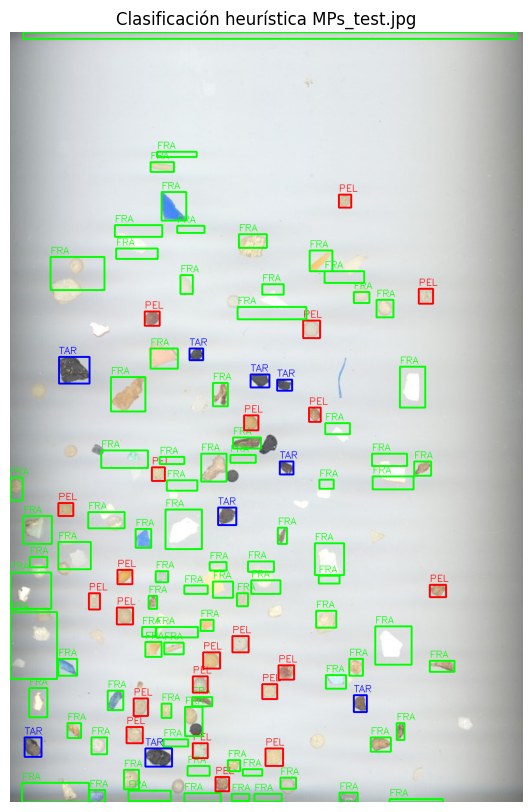

Accuracy=0.8226, Precision=0.8685, Recall=0.8100, F1=0.8290


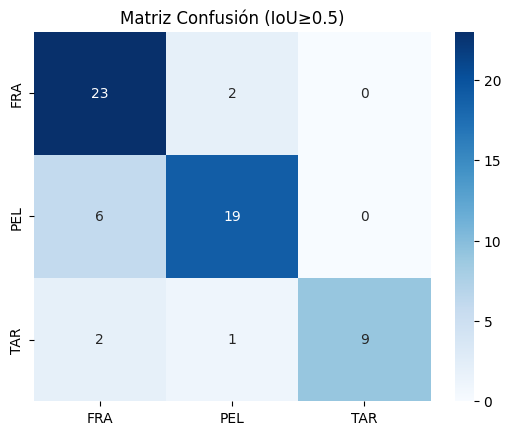

In [17]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# ===========================================================
# CONFIGURACIÓN
# ===========================================================
class Args:
    def __init__(self):
        self.train_images = [
            'fragment-03-olympus-10-01-2020.JPG',
            'pellet-03-olympus-10-01-2020.JPG',
            'tar-03-olympus-10-01-2020.JPG'
        ]
        self.test_image = 'MPs_test.jpg'
        self.test_csv = 'MPs_test_bbs.csv'
        self.output_dir = 'output_model'
        self.min_area_px = 80
        self.debug = True
        self.save_features = True
        self.save_masks = False

# Pesos heurísticos para clasificación ponderada
feature_weights = {
    "area": 3.5,
    "perimetro": 2.4,
    "compact": 4.5,
    "rel_area_cont": 2.25,
    "rel_aspecto": 3.5,
    "rel_ejes": 4.0,
    "rel_dist_centroid": 5.3,
    "black_dist": 3.5,
}

colores_bgr = {'FRA': (0,255,0), 'PEL': (0,0,255), 'TAR': (255,0,0), 'UNK': (128,128,128)}
clases = sorted(list(colores_bgr.keys())[:-1])  # ['FRA','PEL','TAR']

# ===========================================================
# FUNCIONES AUXILIARES
# ===========================================================

def iou_boxes(boxA, boxB):
    xA, yA, wA, hA = boxA
    xB, yB, wB, hB = boxB
    xA2, yA2, xB2, yB2 = xA+wA, yA+hA, xB+wB, yB+hB
    inter_w = max(0, min(xA2, xB2) - max(xA, xB))
    inter_h = max(0, min(yA2, yB2) - max(yA, yB))
    inter = inter_w * inter_h
    union = wA*hA + wB*hB - inter
    return inter / union if union else 0

def build_binary_mask(img_bgr, morph_kernel_size=5, debug=False):
    """Construye máscara binaria robusta usando CLAHE y umbral adaptativo"""
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge([l_eq, a, b])
    img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    blur = cv2.bilateralFilter(cv2.cvtColor(img_eq, cv2.COLOR_BGR2GRAY), 9, 75, 75)
    mask_adapt = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 35, 5)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
    mask_clean = cv2.morphologyEx(mask_adapt, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)
    flood = mask_clean.copy()
    h,w = flood.shape[:2]
    mask_ff = np.zeros((h+2,w+2), np.uint8)
    cv2.floodFill(flood, mask_ff, (0,0), 255)
    mask_final = mask_clean | cv2.bitwise_not(flood)
    return img_eq, mask_final

def detectar_contornos_validos(img, min_area=300, max_area=10000, solapamiento_minimo=True):
    """Detecta contornos válidos usando build_binary_mask y filtrado posterior"""
    img_eq, mask = build_binary_mask(img)
    contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]

    to_remove = set()
    for i in range(len(contours)):
        for j in range(i+1,len(contours)):
            val = iou_boxes(cv2.boundingRect(contours[i]), cv2.boundingRect(contours[j]))
            if val>0:
                if cv2.contourArea(contours[i]) < cv2.contourArea(contours[j]): 
                    to_remove.add(i)
                else: 
                    to_remove.add(j)

    return [c for k,c in enumerate(contours) if k not in to_remove]

def extraer_features_contornos(img, contours):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, rects = [], []
    for c in contours:
        area = cv2.contourArea(c)
        if area==0: continue
        perimetro = cv2.arcLength(c, True)
        x,y,w,h = cv2.boundingRect(c)
        rel_aspecto = w/h if h else 0
        rel_area_cont = area/(w*h) if w*h else 0
        compact = (perimetro**2)/(4*np.pi*area)
        rel_ejes = 0
        if len(c)>=5:
            try: (xc,yc),(MA,ma),ang=cv2.fitEllipse(c); rel_ejes=ma/MA if MA else 0
            except: rel_ejes=0
        M = cv2.moments(c)
        cx,cy=(int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])) if M["m00"] else (0,0)
        dists=[np.linalg.norm(np.array([cx,cy])-pt[0]) for pt in c]
        rel_dist_centroid=min(dists)/max(dists) if dists and max(dists)!=0 else 0
        mask_obj = np.zeros(gray.shape,np.uint8)
        cv2.drawContours(mask_obj,[c],-1,255,-1)
        mean_color = cv2.mean(img, mask=mask_obj)[:3]
        black_dist = np.linalg.norm(np.array(mean_color)-np.array([0,0,0]))
        features.append([area, perimetro, compact, rel_area_cont,
                         rel_aspecto, rel_ejes, rel_dist_centroid, black_dist])
        rects.append((x,y,w,h))
    return np.array(features), rects

def clasificar_normalizado_ponderado(x, features_train_norm, mu, sigma, weights):
    x_norm=(x-mu)/sigma
    w_values=np.array(list(weights.values()))
    dist={}
    for clase,muestras in features_train_norm.items():
        dists=[np.sqrt(np.sum((x_norm-v)**2*w_values**2)) for v in muestras]
        dist[clase]=np.mean(dists)
    return min(dist,key=dist.get)

# ===========================================================
# ENTRENAMIENTO
# ===========================================================
def entrenar_pipeline(train_images_dict):
    features_train={}
    for clase,f in train_images_dict.items():
        feats,_=procesar_imagen(f)
        if feats is not None: features_train[clase]=feats
    X_train=np.vstack([features_train[c] for c in clases if c in features_train])
    mu,sigma=np.mean(X_train,axis=0),np.std(X_train,axis=0)+1e-6
    features_train_norm={c:(features_train[c]-mu)/sigma for c in features_train}
    return features_train_norm, mu, sigma

def procesar_imagen(img_file, min_area=300, max_area=10000):
    img=cv2.imread(img_file)
    if img is None: return None,None
    contornos=detectar_contornos_validos(img,min_area,max_area)
    feats,rects=extraer_features_contornos(img,contornos)
    return feats,rects

# ===========================================================
# TEST Y EVALUACIÓN
# ===========================================================
def test_y_evaluar(test_img_file,test_csv,features_train_norm,mu,sigma):
    img_color=cv2.imread(test_img_file)
    contornos_test=detectar_contornos_validos(img_color,150,12000)
    features_test,rects_test=extraer_features_contornos(img_color,contornos_test)
    img_classified=img_color.copy()
    y_pred=[]
    for f,rect in zip(features_test,rects_test):
        pred=clasificar_normalizado_ponderado(f,features_train_norm,mu,sigma,feature_weights)
        y_pred.append(pred)
        x,y,w,h=rect
        color=colores_bgr.get(pred,(128,128,128))
        cv2.rectangle(img_classified,(x,y),(x+w,y+h),color,2)
        cv2.putText(img_classified,pred,(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1)
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img_classified,cv2.COLOR_BGR2RGB))
    plt.title(f"Clasificación heurística {test_img_file}"); plt.axis('off'); plt.show()

    # Cargar GT
    annotations=[]
    with open(test_csv,newline='') as file:
        reader=csv.DictReader(file)
        for row in reader:
            x_min,y_min,x_max,y_max=map(int,[row["x_min"],row["y_min"],row["x_max"],row["y_max"]])
            annotations.append({"label":row["label"],"rect":(x_min,y_min,x_max-x_min,y_max-y_min)})

    IOU_THRESHOLD=0.5
    y_true,y_pred_match,used_gt=[],[],set()
    for pred_rect,pred_label in zip(rects_test,y_pred):
        best_iou,best_idx=0,-1
        for j,gt in enumerate(annotations):
            if j not in used_gt:
                iou_val=iou_boxes(pred_rect,gt["rect"])
                if iou_val>best_iou: best_iou,best_idx=iou_val,j
        if best_iou>=IOU_THRESHOLD:
            gt_label=annotations[best_idx]["label"]
            if gt_label in clases:
                y_true.append(gt_label)
                y_pred_match.append(pred_label)
                used_gt.add(best_idx)

    if y_true:
        acc=accuracy_score(y_true,y_pred_match)
        prec=precision_score(y_true,y_pred_match,labels=clases,average='macro',zero_division=0)
        rec=recall_score(y_true,y_pred_match,labels=clases,average='macro',zero_division=0)
        f1=f1_score(y_true,y_pred_match,labels=clases,average='macro',zero_division=0)
        print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
        cm=confusion_matrix(y_true,y_pred_match,labels=clases)
        sns.heatmap(pd.DataFrame(cm,index=clases,columns=clases),annot=True,fmt="d",cmap="Blues")
        plt.title("Matriz Confusión (IoU≥0.5)"); plt.show()
    else:
        print("No se pudieron calcular métricas (sin coincidencias IoU≥0.5)")

# ===========================================================
# EJECUCIÓN PRINCIPAL CON VISUALIZACIÓN DE DETECCIONES EN TRAIN
# ===========================================================
if __name__=="__main__":
    args = Args()
    os.makedirs(args.output_dir, exist_ok=True)

    # Diccionario de imágenes de entrenamiento
    train_images_dict = {'FRA': args.train_images[0],
                         'PEL': args.train_images[1],
                         'TAR': args.train_images[2]}

    # Procesar imágenes de entrenamiento y mostrar detecciones
    for clase, img_file in train_images_dict.items():
        feats, rects = procesar_imagen(img_file)
        img = cv2.imread(img_file)
        img_vis = img.copy()
        if feats is not None:
            for rect in rects:
                x, y, w, h = rect
                color = colores_bgr.get(clase, (128,128,128))
                cv2.rectangle(img_vis, (x, y), (x+w, y+h), color, 2)
                cv2.putText(img_vis, clase, (x, max(15,y-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            print(f"[INFO] Imagen {img_file} - detecciones visualizadas ({len(rects)} contornos)")
        else:
            print(f"[WARN] No se detectaron contornos válidos en {img_file}")

        plt.figure(figsize=(10,10))
        plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        plt.title(f"Detecciones en entrenamiento: {clase}")
        plt.axis("off")
        plt.show()

    # Entrenamiento del pipeline normal
    features_train_norm, mu, sigma = entrenar_pipeline(train_images_dict)

    # Test y evaluación
    test_y_evaluar(args.test_image, args.test_csv, features_train_norm, mu, sigma)
